### Introduction

The data consists of the information about the candidates that attended to a big data course, conducted by a company. The company would like to predict in advance the real potential candidates for themselves. Thus, they want to reduce the cost and focus on the most likely candidates.

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import argmax
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
#https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists
data = pd.read_csv("aug_train.csv")

In [3]:
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
enrollee_id,19158.0,16875.358179,9616.292592,1.000,8554.25,16982.500,25169.75,33380.000
city_development_index,19158.0,0.828848,0.123362,0.448,0.74,0.903,0.92,0.949
training_hours,19158.0,65.366896,60.058462,1.000,23.00,47.000,88.00,336.000
target,19158.0,0.249348,0.432647,0.000,0.00,0.000,0.00,1.000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
enrollee_id               19158 non-null int64
city                      19158 non-null object
city_development_index    19158 non-null float64
gender                    14650 non-null object
relevent_experience       19158 non-null object
enrolled_university       18772 non-null object
education_level           18698 non-null object
major_discipline          16345 non-null object
experience                19093 non-null object
company_size              13220 non-null object
company_type              13018 non-null object
last_new_job              18735 non-null object
training_hours            19158 non-null int64
target                    19158 non-null float64
dtypes: float64(2), int64(2), object(10)
memory usage: 2.0+ MB


There are 4 numeric, 10 categoric variables in dataset

In [6]:
miss_val = data.isnull().sum()
miss_val=miss_val.drop(miss_val[miss_val == 0].index).sort_values(ascending = False)
pd.DataFrame({'Missing Values':miss_val, 'Percent':miss_val/len(data)*100})

,Missing Values,Percent
company_type,6140,32.049274
company_size,5938,30.994885
gender,4508,23.530640
major_discipline,2813,14.683161
education_level,460,2.401086
last_new_job,423,2.207955
enrolled_university,386,2.014824
experience,65,0.339284


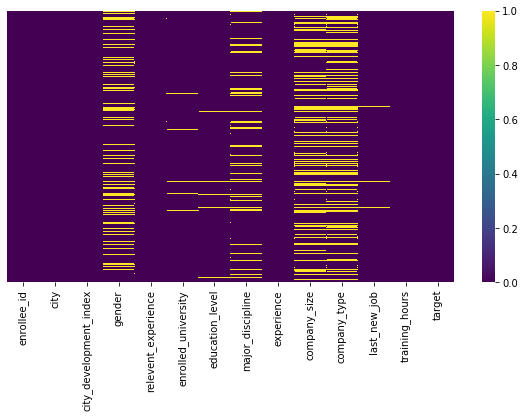

In [7]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(data.isnull(), yticklabels="", cmap="viridis")

There are considerable amount of missing data, but before dealing with them I will investigate the dataset visually

### Data Visualization & Data Preprocessing

The target column represents people who are looking for a new job. If the value is 1 it means that person looking for a job and 0 otherwise

Text(0, 0.5, 'Count')

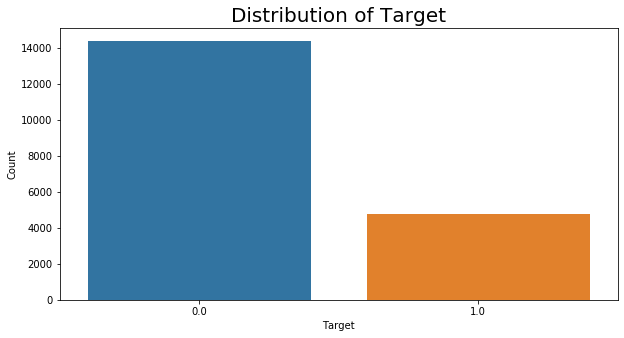

In [8]:
fig=plt.figure(figsize=(10,5))
sns.barplot(data["target"].value_counts().index, data["target"].value_counts())
plt.title("Distribution of Target", size=20)
plt.xlabel("Target", size=10)
plt.ylabel("Count", size=10)

We can consider the dataset as imbalanced, since only 25% of total actually looking for a new job

Text(0, 0.5, 'Count')

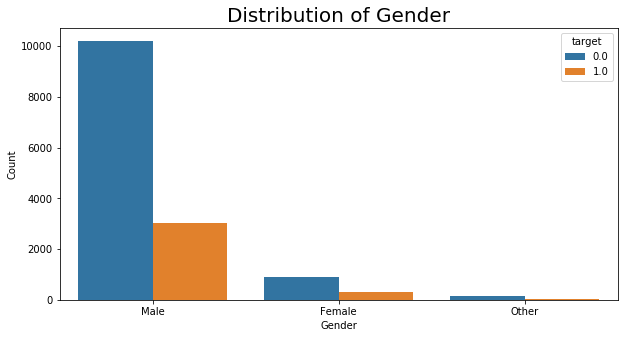

In [9]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["gender"], hue=data["target"])
plt.title("Distribution of Gender", size=20)
plt.xlabel("Gender", size=10)
plt.ylabel("Count", size=10)

There are also 23% unknown gender information. To show the all distribution of target value by gender, I will fill the missing values now. There is a huge gap between male and female. I don't want to effect the ratio between them, therefore I will fill the NA values by "unknown"

In [10]:
data["gender"]=data["gender"].fillna(value="unknown")

Text(0, 0.5, 'Count')

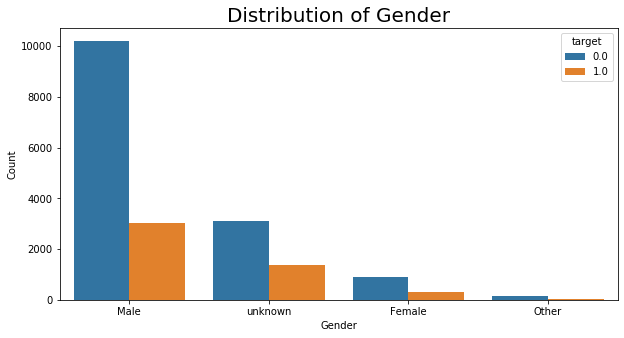

In [12]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["gender"], hue=data["target"])
plt.title("Distribution of Gender", size=20)
plt.xlabel("Gender", size=10)
plt.ylabel("Count", size=10)

Text(0, 0.5, 'Count')

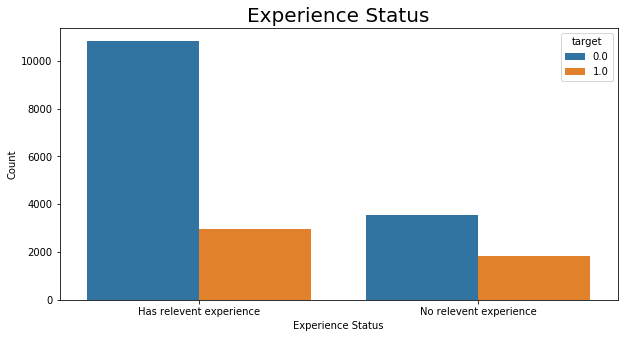

In [13]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["relevent_experience"], hue=data["target"])
plt.title("Experience Status", size=20)
plt.xlabel("Experience Status", size=10)
plt.ylabel("Count", size=10)

It seems, people who has no relevent experience are more tend to change their jobs

Text(0, 0.5, 'Count')

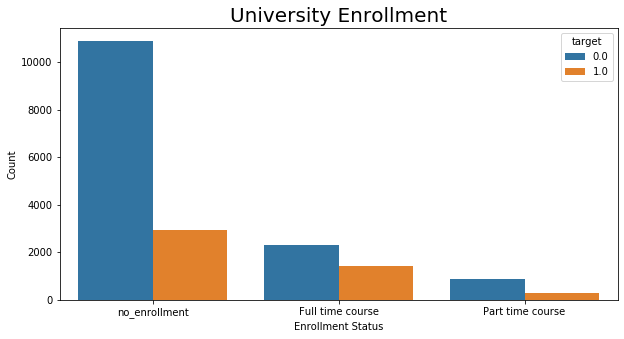

In [14]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["enrolled_university"], hue=data["target"])
plt.title("University Enrollment", size=20)
plt.xlabel("Enrollment Status", size=10)
plt.ylabel("Count", size=10)

Text(0, 0.5, 'Count')

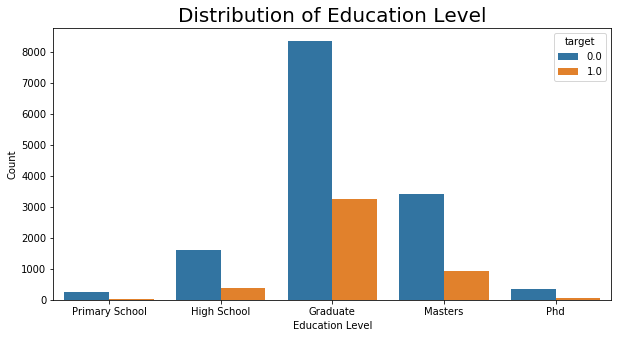

In [15]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["education_level"], order=["Primary School","High School","Graduate","Masters","Phd"],hue=data["target"])
plt.title("Distribution of Education Level", size=20)
plt.xlabel("Education Level", size=10)
plt.ylabel("Count", size=10)

Text(0, 0.5, 'Count')

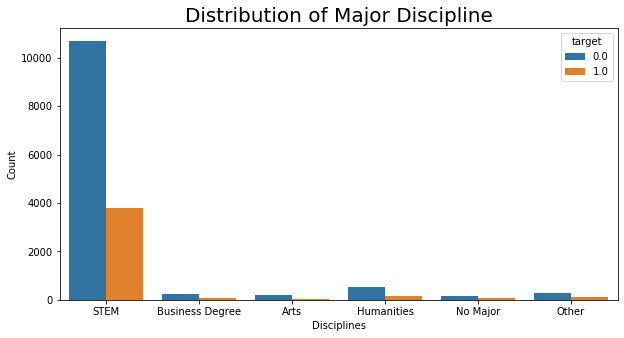

In [16]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["major_discipline"], hue=data["target"])
plt.title("Distribution of Major Discipline", size=20)
plt.xlabel("Disciplines", size=10)
plt.ylabel("Count", size=10)

Text(0, 0.5, 'Count')

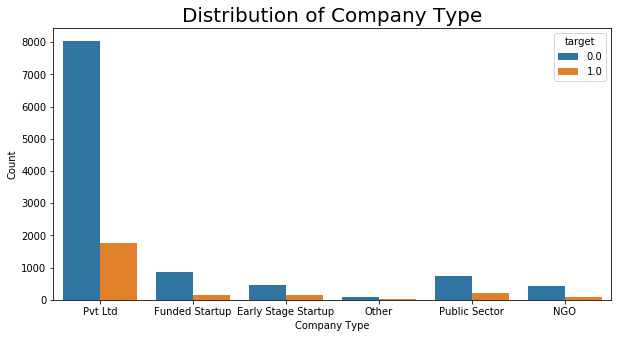

In [16]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["company_type"], hue=data["target"])
plt.title("Distribution of Company Type", size=20)
plt.xlabel("Company Type", size=10)
plt.ylabel("Count", size=10)

Text(0, 0.5, 'Count')

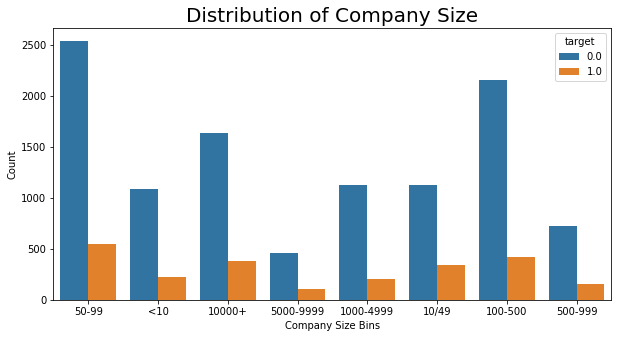

In [17]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["company_size"], hue=data["target"])
plt.title("Distribution of Company Size", size=20)
plt.xlabel("Company Size Bins", size=10)
plt.ylabel("Count", size=10)

Text(0, 0.5, 'Count')

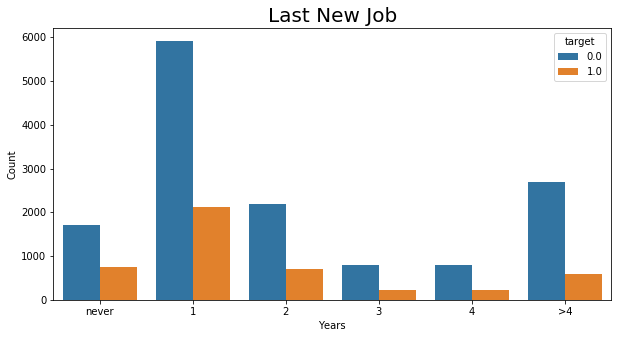

In [18]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["last_new_job"],order=["never","1","2","3","4",">4"], hue=data["target"])
plt.title("Last New Job", size=20)
plt.xlabel("Years", size=10)
plt.ylabel("Count", size=10)

We can interpret that visually, the graphs of "University Enrollment", "Education Level", "Major Discipline", "Company Type", "Company Size" and "Last New Job" don't have any specific effect on target value

To present a better visualization for "traing hours" and "experience" variables, I will separate them to bins

In [19]:
data["train_bins"]=pd.cut(data["training_hours"], [0,50,100,150,200,250,300,350],labels=["<0","50-100","100-150","150-200","200-250","250-300","300>"])

Text(0, 0.5, 'Count')

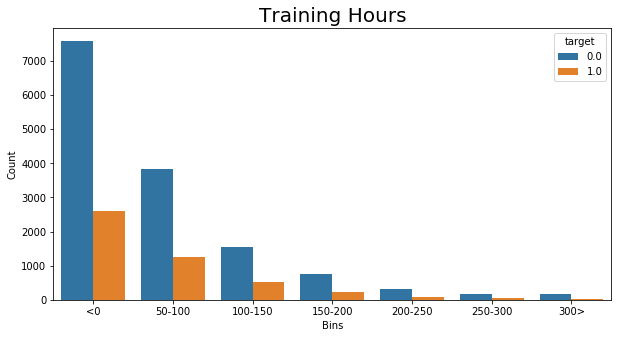

In [20]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["train_bins"], hue=data["target"])
plt.title("Training Hours", size=20)
plt.xlabel("Bins", size=10)
plt.ylabel("Count", size=10)

It can be seen that, the ratio of willing to changing their job against to not willing candidates increases when the training hours increases as well.

In [21]:
def exp_bin(x):
    if x == "<1":
        return "<1"
    if x == "1":
        return "1-5"
    if x == "2":
        return "1-5"
    if x == "3":
        return "1-5"
    if x == "4":
        return "1-5"
    if x == "5":
        return "1-5"
    if x == "6":
        return "5-10"
    if x == "7":
        return "5-10"
    if x == "8":
        return "5-10"
    if x == "9":
        return "5-10"
    if x == "10":
        return "5-10"
    if x == "11":
        return "10-15"
    if x == "12":
        return "10-15"
    if x == "13":
        return "10-15"
    if x == "14":
        return "10-15"
    if x == "15":
        return "10-15"
    if x == "16":
        return "15-20"
    if x == "17":
        return "15-20"
    if x == "18":
        return "15-20"
    if x == "19":
        return "15-20"
    if x == "20":
        return "15-20"
    if x == ">20":
        return ">20"    
    

In [22]:
data["exp_range"]=data["experience"].apply(exp_bin)

Text(0, 0.5, 'Count')

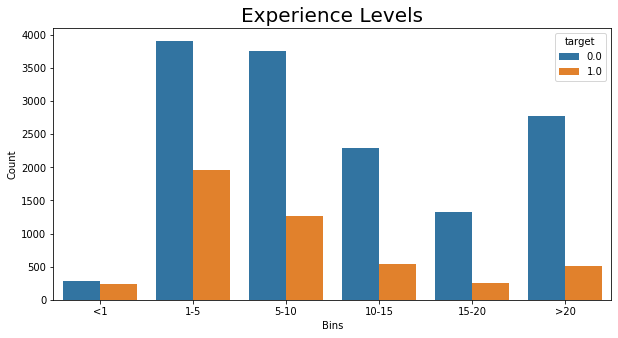

In [23]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["exp_range"], order=["<1", "1-5","5-10","10-15","15-20",">20"],hue=data["target"])
plt.title("Experience Levels", size=20)
plt.xlabel("Bins", size=10)
plt.ylabel("Count", size=10)

According to the graph above, people who have experience less than a year more likely to change their jobs. On the other hand, after their first year, the ratio of willingness to changing job decreases significantly.

A new feature is added as the groups of cities based on the citi_development_index. As can be seen in the descriptive statistics, their quarterly values are used as the boundries.

In [24]:
def index_group(x):
    if x < 0.74:
        return "Q1"
    if x >=0.74 and x < 0.903:
        return "Q2"
    if x >= 0.903 and x < 0.92:
        return "Q3"
    if x >= 0.92:
        return "Q4"

In [25]:
data["dev_index_group"] = data["city_development_index"].apply(index_group)

Text(0, 0.5, 'Count')

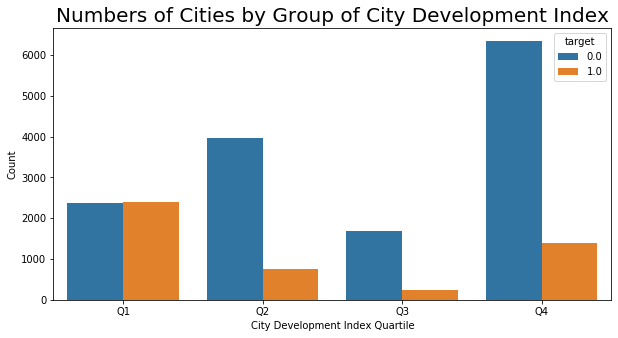

In [26]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data["dev_index_group"],order=["Q1","Q2","Q3","Q4"], hue=data["target"])
plt.title("Numbers of Cities by Group of City Development Index", size=20)
plt.xlabel("City Development Index Quartile", size=10)
plt.ylabel("Count", size=10)

Roughly we can say that, in the cities that have the least city development index, people are tend to change their jobs.

In [27]:
data.groupby("city").agg({"city_development_index":"mean", "enrollee_id":"count"}).sort_values("enrollee_id", ascending=False).head(15)

,city_development_index,enrollee_id
city,,
city_103,0.920,4355
city_21,0.624,2702
city_16,0.910,1533
city_114,0.926,1336
city_160,0.920,845
city_136,0.897,586
city_67,0.855,431
city_75,0.939,305
city_102,0.804,304


The most crowded 15 cities' city development indexes can be seen above

For a better understanding about the effect of the city on the decision of changing the job, all cities are examined by their groups of development indexes as follows;

Text(0, 0.5, 'Count')

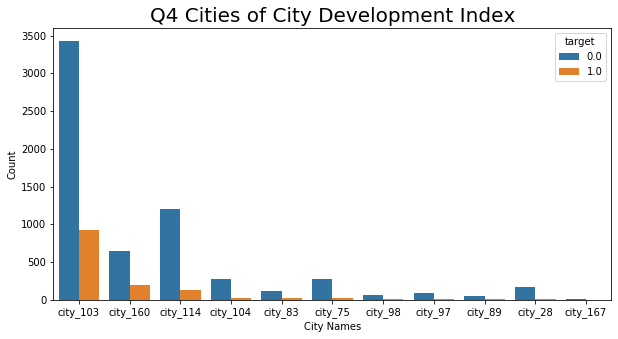

In [28]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data[data["dev_index_group"]=="Q4"]["city"], hue=data["target"])
plt.title("Q4 Cities of City Development Index", size=20)
plt.xlabel("City Names", size=10)
plt.ylabel("Count", size=10)

Text(0, 0.5, 'Count')

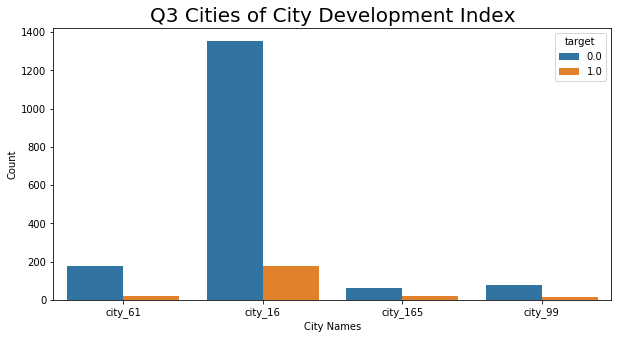

In [29]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data[data["dev_index_group"]=="Q3"]["city"], hue=data["target"])
plt.title("Q3 Cities of City Development Index", size=20)
plt.xlabel("City Names", size=10)
plt.ylabel("Count", size=10)

Text(0, 0.5, 'Count')

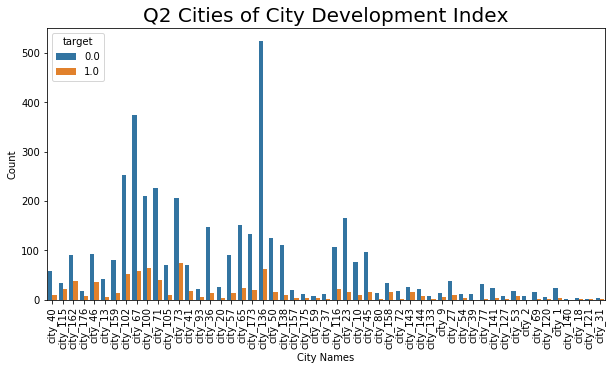

In [30]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data[data["dev_index_group"]=="Q2"]["city"], hue=data["target"])
plt.xticks(rotation=90)
plt.title("Q2 Cities of City Development Index", size=20)
plt.xlabel("City Names", size=10)
plt.ylabel("Count", size=10)

Text(0, 0.5, 'Count')

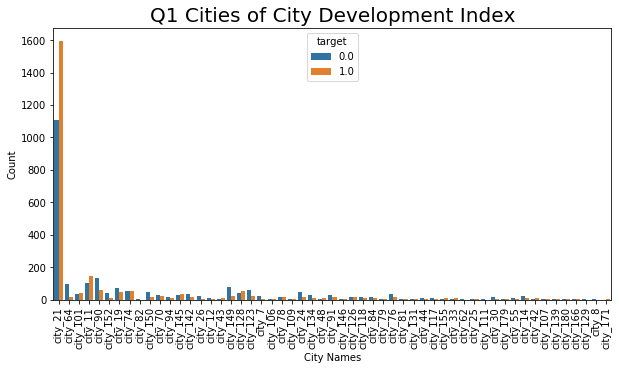

In [31]:
fig=plt.figure(figsize=(10,5))
sns.countplot(data[data["dev_index_group"]=="Q1"]["city"], hue=data["target"])
plt.xticks(rotation=90)
plt.title("Q1 Cities of City Development Index", size=20)
plt.xlabel("City Names", size=10)
plt.ylabel("Count", size=10)

In the most crowded city, named city_103, has one of the greatest development index and the ratio of willing to change job is quite low. On the other hand, in the second crowded city, named city_21, has one of the lowest development index and there are more people who tend to change their jobs than the others.

It can be observed that, most of the cities development index are below second quarter.

In [32]:
table = pd.pivot_table(data, index="city", values="enrollee_id",columns="target", aggfunc="count", margins=True)
table=table.iloc[:-1]
table.fillna(value=0,inplace=True)
table["job_changing_index"]=round(table[1]/table[0]*100)
table.drop([0,1], axis=1, inplace=True)
table[table["All"]>250].sort_values("job_changing_index", ascending=False)

target,All,job_changing_index
city,,
city_21,2702,145.0
city_73,280,36.0
city_100,275,31.0
city_160,845,31.0
city_103,4355,27.0
city_102,304,21.0
city_71,266,17.0
city_67,431,15.0
city_16,1533,13.0


The table above shows the cities that have more than 250 residents and having the highest job changing index.

Job changing index = # of people willing to change job / # of people not willing to change job

In [33]:
miss_val = data.isnull().sum()
miss_val=miss_val.drop(miss_val[miss_val == 0].index).sort_values(ascending = False)
pd.DataFrame({'Missing Values':miss_val, 'Percent':miss_val/len(data)*100})

,Missing Values,Percent
company_type,6140,32.049274
company_size,5938,30.994885
major_discipline,2813,14.683161
education_level,460,2.401086
last_new_job,423,2.207955
enrolled_university,386,2.014824
exp_range,65,0.339284
experience,65,0.339284


Since it doesn't seems there is a rational relationship between looking for a new job and company type or company size, and there are a lot of missing values, I decide to drop the both column

In [34]:
data.drop(["company_type","company_size"],axis=1, inplace=True)

Then, the rest of the missing data are filled by the most frequent values for each variable

In [35]:
#https://stackoverflow.com/questions/32617811/imputation-of-missing-values-for-categories-in-pandas
data=data.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [36]:
miss_val = data.isnull().sum()
miss_val=miss_val.drop(miss_val[miss_val == 0].index).sort_values(ascending = False)
pd.DataFrame({'Missing Values':miss_val, 'Percent':miss_val/len(data)*100})

,Missing Values,Percent


In the final step of data pre-processing, one new feature will be added in the dataset named "city_target_rate". This new feature represents the rate of the positive target values against the total in the specified city.

In [37]:
def city_rate(x):
    rate = data[(data["city"]==x)&(data["target"]==1)].count()/data[data["city"]==x].count()
    return rate[0].round(2)

In [38]:
data["city_target_rate"]=data["city"].apply(city_rate)

Most of the data have categorical values, therefore One-Hot Encoding approach will be applied to the data.

In [39]:
data_dummies=pd.get_dummies(data)

### Modelling

In [40]:
y = data_dummies["target"]
X = data_dummies.drop(["target"], axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Bernoulli Naive Bayes

In [42]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
y_pred= nb.predict(X_test)

In [43]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3539  758]
 [ 590  861]]
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      4297
         1.0       0.53      0.59      0.56      1451

    accuracy                           0.77      5748
   macro avg       0.69      0.71      0.70      5748
weighted avg       0.77      0.77      0.77      5748



#### Support Vector Classifier

In [44]:
svc = SVC(C=1, kernel="sigmoid")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [45]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3247 1050]
 [1115  336]]
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      4297
         1.0       0.24      0.23      0.24      1451

    accuracy                           0.62      5748
   macro avg       0.49      0.49      0.49      5748
weighted avg       0.62      0.62      0.62      5748



In [46]:
svc = SVC(C=0.1, kernel="sigmoid")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [47]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3337  960]
 [1133  318]]
              precision    recall  f1-score   support

         0.0       0.75      0.78      0.76      4297
         1.0       0.25      0.22      0.23      1451

    accuracy                           0.64      5748
   macro avg       0.50      0.50      0.50      5748
weighted avg       0.62      0.64      0.63      5748



#### Decision Tree

In [48]:
parameters={'min_samples_leaf':[50,100,150],
            'criterion':('entropy', 'gini'), 
            'max_depth':[5,10,20]}
grid=GridSearchCV(DecisionTreeClassifier(), parameters)

In [49]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('entropy', 'gini'),
                         'max_depth': [5, 10, 20],
                         'min_samples_leaf': [50, 100, 150]})

In [50]:
print(grid.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 150}


In [51]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))

[[3953  344]
 [ 891  560]]
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.86      4297
         1.0       0.62      0.39      0.48      1451

    accuracy                           0.79      5748
   macro avg       0.72      0.65      0.67      5748
weighted avg       0.77      0.79      0.77      5748



#### Random Forest

In [84]:
forest=RandomForestClassifier(criterion='entropy', max_depth=10)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

In [85]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3935  362]
 [ 844  607]]
              precision    recall  f1-score   support

         0.0       0.82      0.92      0.87      4297
         1.0       0.63      0.42      0.50      1451

    accuracy                           0.79      5748
   macro avg       0.72      0.67      0.68      5748
weighted avg       0.77      0.79      0.77      5748



#### Logistic Regression

In [56]:
logistic=LogisticRegression()
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

In [57]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4219   78]
 [1339  112]]
              precision    recall  f1-score   support

         0.0       0.76      0.98      0.86      4297
         1.0       0.59      0.08      0.14      1451

    accuracy                           0.75      5748
   macro avg       0.67      0.53      0.50      5748
weighted avg       0.72      0.75      0.67      5748



#### XGBoost

XGboost algorithms doesn't accept any column name that contains '[', ']' or '<'. Therefore columnnames will be arranged before applying the algorithm

In [60]:
xg_data=data_dummies
xg_data.columns = xg_data.columns.str.replace("[<]", "less")
xg_data.columns = xg_data.columns.str.replace("[>]", "greater")
xg_data.columns = xg_data.columns.str.replace("['[']", "(")
xg_data.columns = xg_data.columns.str.replace("[']']", ")")

In [61]:
y_boost = xg_data["target"]
X_boost = xg_data.drop(["target"], axis=1)

In [62]:
X_train_boost, X_test_boost, y_train_boost, y_test_boost = train_test_split(X_boost, y_boost, test_size=0.3)

In [65]:
xgb = XGBClassifier()

xgb.fit(X_train_boost, y_train_boost)
y_pred_boost=xgb.predict(X_test_boost)

In [66]:
print(confusion_matrix(y_test_boost, y_pred_boost))
print(classification_report(y_test_boost, y_pred_boost))

[[3834  472]
 [ 910  532]]
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      4306
         1.0       0.53      0.37      0.43      1442

    accuracy                           0.76      5748
   macro avg       0.67      0.63      0.64      5748
weighted avg       0.74      0.76      0.74      5748



Based on the results of the algorithms above, all have similar results. Even though accuracies are not bad, since the data is imbalanced, precision and recall values would be more deterministic in this case. Therefore, the weights should be take into acount as well.

The class weight could be set as "balanced". "Balanced" parameter sets the weights based on their frequencies 

### Weighted Modelling

#### Weighted Support Vector Classifier

In [67]:
w_svc = SVC(C=0.1, kernel="sigmoid", class_weight="balanced")
w_svc.fit(X_train, y_train)
y_pred = w_svc.predict(X_test)

In [68]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2176 2121]
 [ 767  684]]
              precision    recall  f1-score   support

         0.0       0.74      0.51      0.60      4297
         1.0       0.24      0.47      0.32      1451

    accuracy                           0.50      5748
   macro avg       0.49      0.49      0.46      5748
weighted avg       0.61      0.50      0.53      5748



Although the accuracy dropped to 50%, recall values increased. But it is not enough for a reasonable prediction

#### Weighted Decision Tree

In [72]:
w_dtree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=150, class_weight="balanced")
w_dtree = w_dtree.fit(X_train, y_train)
y_pred=w_dtree.predict(X_test)

In [73]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3218 1079]
 [ 448 1003]]
              precision    recall  f1-score   support

         0.0       0.88      0.75      0.81      4297
         1.0       0.48      0.69      0.57      1451

    accuracy                           0.73      5748
   macro avg       0.68      0.72      0.69      5748
weighted avg       0.78      0.73      0.75      5748



#### Weighted Random Forest

In [94]:
w_forest=RandomForestClassifier(criterion='entropy', max_depth=10, class_weight="balanced")
w_forest.fit(X_train,y_train)
y_pred = w_forest.predict(X_test)

In [95]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3512  785]
 [ 541  910]]
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84      4297
         1.0       0.54      0.63      0.58      1451

    accuracy                           0.77      5748
   macro avg       0.70      0.72      0.71      5748
weighted avg       0.78      0.77      0.77      5748



#### Weighted Logistic Regression

In [111]:
w_logistic=LogisticRegression(max_iter= 200,C=1, class_weight="balanced")
w_logistic.fit(X_train, y_train)
y_pred = w_logistic.predict(X_test)

In [112]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3214 1083]
 [ 506  945]]
              precision    recall  f1-score   support

         0.0       0.86      0.75      0.80      4297
         1.0       0.47      0.65      0.54      1451

    accuracy                           0.72      5748
   macro avg       0.66      0.70      0.67      5748
weighted avg       0.76      0.72      0.74      5748



In conclusion, using weighted algorithms slightly improved the accuracies, but precision and recall values become more reasonable for predicting less occured observations. Weighted Random Forest algoritm has the best results amongst the other algorithms. For the further analysis, the data should be processed and better feature engineering would give better results.